# Intro: Training and Deploying a Deep Learning Model

This notebook provides an intro to Deep Learning in the field of computer vision. It basically contain all of my notes from taking the first two lessons of the "Deep Learning for Coders" course from fastai and additionally reading the chapters in the respective book. 

I highly recommend checking out the book and the online course, they are really great with an amazing community and best of all, both the book and the online course are free!

Deep Learning is a subfield of Machine Learning in the Universe of Artificial Intelligence. There are so many areas where Deep Learning is used and delivers great results. Here are the most famous of them: Natural Language Processing (NLP), Computer Vision, Recommendation Systems, Robotics, Games and much, much more.

With this notebook I am dipping my toes into computer vision. I love unicorns, but I have never actually seen one. Or at least I think so. To be absolutely sure in the future, I want to build a unicorn detector. Maybe I have seen one before just never recognized it. So I want the computer to tell me if I have a picture of a unicorn or not.

If we would write a „normal” computer program to tell us if we have a picture of a unicorn or not, that would be an impossible task. It is very hard to write a program that can detect a unicorn because what logic would go into it? When we write a normal program, like one that can sort numbers, we now how to implement the logic. Look at two numbers, decide which one is greater and order them accordingly. But how would we write the logic to detect a unicorn? In Deep Learning, we just feed the program, called a model, data, in our case a lot of pictures of unicorns and the model learns to detect unicorns itself.

When we say we feed the model the picture, we need to do it in a way the computer understands. In the case of a picture this are the values of every single pixel. This are the inputs to the model.

In a neural network, the information you feed it gets pushed through all the layers. Each layer refines the inputs that it gets from the previous one. For this, we need something that defines how each layer operates. This is called the weights. Weights are variables that are assigned a certain value for each layer of the model, and they determine if the model can recognize a cat or a unicorn. The weights need to be initialized at the start of the training process (for example set to random numbers) and they are changed during the training process. 

Every layer is trained by an algorithm that minimizes the error of the layer and improves the accuracy. Based on the results a model with a certain set of weights gives us, we need to measure the performance. How good is our model at recognizing unicorns? How far off is it? Based on this, we can update the weights in a direction that makes the model perform better. This is done automatically and is called training step. This training step is done a lot of times until the network can perform a certain task. We say the model learns.

# The code

In [1]:
# environment setup
# setup kaggle and install duckduckgo search
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [2]:
# import all modules we need
from duckduckgo_search import ddg_images
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from time import sleep

## Step 1: Download images of unicorns and horses

In [3]:
# define a function to search for images in duckduckgo with a specific search term
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
# search for an image of a unicorn and get the url
urls = search_images('unicorn pictures', max_images=1)
urls[0]

Searching for 'unicorn pictures'


'https://assets.entrepreneur.com/content/3x2/2000/20151103215252-unicorn-rainbow-magical-fiction-beautiful.jpeg'

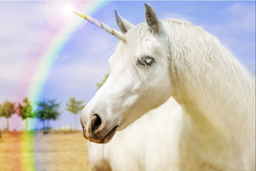

In [5]:
# save the picture from the url to a file called unicorn.jpg
dest = 'unicorn.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'horse pictures'


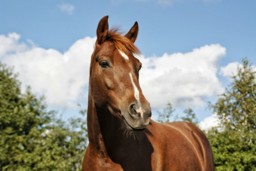

In [6]:
# do the same for a horse
urls = search_images('horse pictures', max_images=1)
dest = 'horse.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [7]:
# grab a bunch of photos for unicorns and horses
searches = 'unicorn', 'horse' # set the search terms
path = Path('unicorn_or_not')

if not path.exists():
    path.mkdir()
    for search in searches:
        dest = (path/search)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{search} pictures'))
        resize_images(path/search, max_size=400, dest=path/search)

Searching for 'unicorn pictures'
Searching for 'horse pictures'


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Step 2: Train the model

If we want to train a model, we need DataLoaders. In fastai we can create a DataLoader using a DataBlock. The DataLoader stores the pictures of unicorns and horses that we pass into it and makes them available as train and valid. To create a DataLoader, we need to tell fastai:
* what kind of data we are working with (ImageBlock and CategoryBlock)
* how to get the items (get_items)
* to create a validation set (RandomSplitter)
* how to label the items (parent_label)

In [9]:
# create a DataBlock object
unicorn_or_horse = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # defines that the inputs are images and outputs are categories
    get_items=get_image_files, # get_image_files returns a list of all image files in a path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # splits the data randomly into training (80%) and validation set (20%)
    get_y=parent_label, # labels are the folder name in which the file is in
    item_tfms=[Resize(192, method='squish')] # resize each image to 192x192 pixels by squishing
)

With the first line, we provide the information what datatypes we have for the independent and dependent variables. The independet variable (x), is the thing we take to make predictions, in our case pictures of unicorns or horses, so we take a ImageBlock. The dependent variable (y) are categories, namely unicorn or horse, so we take a CategoryBlock. 

With the second line, we need to tell fastai how to get the items. In this case, we need the filepath where the pictures are stored. The function 'get_image_files' takes a path and returns a list of all the images in that path. 

The third line creates a test set and a validation set by splitting the images randomly. The 'valid_pct=0.2' tells fastai to split the images 80% in the test set and 20% in the validation set. We also set the random seed, so we have the same training/validation split each time the notebook is run. 

In the next line we tell fastai how it should create the labels for the dataset. The function 'parent_label' simply gets the folder name which the file is in. We put the unicorn pictures in a unicorn folder and the horse pictures in a horse folder, so we get the right labels for each picture. 

Lastly, we also tell the DataLoader that we want to resize the images with the 'squish' method.


Now that we have a DataBlock object, unicorn_or_horse, we have a template for creating a DataLoader. We need to tell fastai the source of the data, which is the path where the images are stored. 'bs=32' tells fastai how many samples per batch to load, in our case 32.

In [10]:
dls = unicorn_or_horse.dataloaders(path, bs=32)

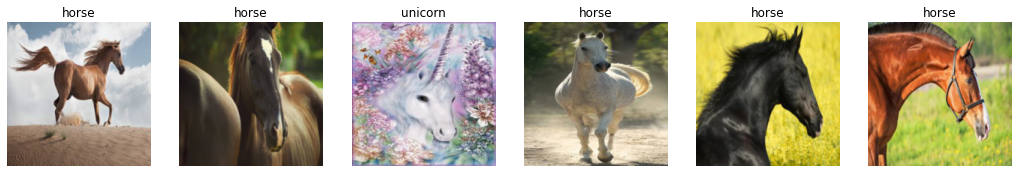

In [11]:
# with .show_batch() we can view some images from our DataLoader
dls.show_batch(max_n=6, nrows=1)

We use an already trained model, resnet18, and only fine-tune it to fit our specific case. With fine-tuning we mean that we adjust the weights of the last few layers so that the model learns to recognize our specific dataset on horses and unicorns. 

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.164354,9.600677,0.636364,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.200972,7.260028,0.636364,00:05
1,0.897124,4.238997,0.636364,00:05
2,0.691357,2.587249,0.636364,00:05


Then we can ask what our model thinks for the pictures we downloaded earlier.

In [13]:
is_unicorn,_,probs = learn.predict('unicorn.jpg')
print(f"This is a: {is_unicorn}.")
print(f"Probability it is a unicorn: {probs[1]:.4f}")

This is a: horse.
Probability it is a unicorn: 0.0055


In [14]:
is_horse,_,probs = learn.predict('horse.jpg')
print(f"This is a: {is_horse}.")
print(f"Probability it is a horse: {probs[0]:.4f}")

This is a: horse.
Probability it is a horse: 1.0000


In [15]:
# download another unicorn picture
url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhUYGRgaGhgYGBkYGhgYGBgaGhgaGhkcGhocIS4lHB4rIRgaJjgmKy8xNTU1GiQ7QDszPy40NTEBDAwMEA8QHhISHjQrJCs0ND00NDQ1PTQ0NDQ0NDQ0NDQ0NDQ9NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAOEA4QMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAADBAABAgUGB//EAEAQAAEDAgQDBQUFBwMEAwAAAAEAAhEDIRIxQVEEYXEFIoGRoTKxweHwE0JS0fEGFBVicpKyM4LCU5Oi0hZjg//EABkBAAMBAQEAAAAAAAAAAAAAAAABAgMEBf/EACURAAICAgMAAQQDAQAAAAAAAAABAhEhMQMSQVEEEyJhFDJxkf/aAAwDAQACEQMRAD8A+gkkrJgZqPqpV9RczZvkO6qFg1kq56tl0k2OkMiqr+3QC1Cxq1YYD1Kyw2qsRKPw/DSqSJbDcNUMpwu3Q6VCDkpVKolsy96A+qo4LDKcp0BYM6KvsAUzSYt4QFNDs5z+BS37rBldoFCqAFAWc+SFh7yUau2Ek96aYNEe/mssegvcsB6BUOtbKp7SFjh3FNROaBC4CmAI/wBnCttKdEAKkhYa5dNnZ7dSis4VjdJKdgcxlFztCiN4QrouqDRLvqJAD/dQotfaqIAYcgvam8MqCms1EvsI/ZlEbTKcFJEbTCaiKxBzFgU099gjMoDZUkKxSjw5TdGnhTDAAqeBomIpz0rVM5IjgsFqABsZuttZCpxVF+yACgperWUcSl6jUAHFayWfxCWfUhKvqp0McfXnNK1m6hLurLVOsjqUmBeVgFOVaYcJCSchZBr0aZxMCyjOJIOaSJVsTok7fDcSD7V1G8Xhdy9FzGF2gKYZSLs0qA6o4oHULLqyRZSKZZT0SEW+rCXPEpxvBSDK59WjBzToLCfvAUSyiBnfVhyOaJ2WDTSEUKiIwystpozGBAGGvujOeBms4LrFUSgCw8FW8whNYre5AGcSyVJWS5AA3laa8BZeUEgoAJUrJd9ZW8Jd7CgAdZyRqOTrqRKw7hU7A5zioyV1WcANSjs4VjUWBzuHY6UWvwRNwE7iaMkRlSEMuLOTR4a9wnWcOBkEXiKJNwhsdCE7FJUWbLTHhYdUQnuQ0SNveEB9VLFxQnOKKGPt4o4HCdQfC/xhJ1KsrbXBk47kiMI0B1JWavDtwh7SYOYOidMmxfGoqwDdRIo9wVhzUQrJSECwojVUqsSACShOKouWC9AEc5Yc5aJWCgDJKw4rTlgoAyVhxWysEIAG4rBKIWrJagDBVStFqzhQBoFZc9ZcEtxNcM2Lj7LZguKLrY0rGHFUChMmL/pyVyhZDQ9RfIhL1aUFVTemKnebzSbp2WsqicNw7XGJTtXspsSDdcfh8ReANTC7HFmo1wcB3Yh21rX6rVZMZWmc6pwB0SdSgRyK9Hw3HMLCQ0iJnXSfguPxfEMJx4YJyaTbr0Q0gTYjxlMy3+lvpb4INKoW5eRyRuIqkxNz7hoPekq74F8puYcYG/duOqhv0rwb+1H4G+qi5H27Pxj+/wCStT3EfRi9YLkPEpKYzRVKpUQBCslQqkAUSskrZCwQgDBKyStELJCAMkrMrbGFxgJtlMNsPPUpSlQJWLN4Y629UPiKWAFznCAJ57pl9TCPG3Vcftam+oC1pAEQTpBF/FZubL6oLwwJpte7N142m9/Cy1KJQOBt7gCCN7SuNXrPe4YQQ38MzkfvHaElypLOxuDbwGrccPuQ68OM2bMx1yRWcOJJN5IIm8W+aJSoNbMAQbxGWv0VshVFSlmX/BNpYRggKiFooa0INUqRcbfJPcOWM1xOjKLTokw2xHNNcM1rbuINj3c76KgKrcQ9r2nC2Cbd0eiC7jC17w6S1xLXCb52g8k/XqtLJDACD3dYOpv4Ln1HQXOHtTrBMAxOWZPxST/YSXtD1FtNkNuTUEQ6O7OUgLi8ae+6wBBixkQjcMSajS4k3BJzMC5TP7gTicAXTlEQ6TmDuNlWxaOQ8yhVHhoJNwNAJT/E0nMGExpIgT4wknM5KWPYp+6s/wCh6NUVfw9n4VFOQ6ntwVoFBBWmlMAsqSsgq5QBFFJUxIAihULlklAFOQ3IhKG5ADHCssTvZSrUidLKVXhoAGlvLNcriuIvA2y6uA+BXNOZpGIQPxOtlHxuVKtbCDa0Gd0LgHd0jK5A9D70V7JCUdDexV/adIMxvcGtJzNpvhEDMkxACZFFoZia2JIJ8d1zOJ7Oa9wcRJaIAvl0yXbo0yWYTqLdVpFZslyehSVhygUK2IMqK4Vh55eSANOEySNPCVhhWXEq2tuEPIIcc7ugcviUi/M80094OWlh0/NLualVMd4KY4tIPQ/otvfIIuMNxykwR4yPJZdFhIkaSJjolXdoMbjBdJAjqZBsdck+yWxMcbXBb32gj2QfvRmFz67XESwSSRlfxtnYHZJcf2q0tLWEkZEtmDBy5zfyyXPZ2qYHcbhF2g2IIyMiFlLmjdWCQ7+8VP8ApP8A7B/7KK//AJNT/C7/ALhUUfcj8jO6/tYNzYfMKN7ZZ+E+YXnv3hg9pxOsbK3FsSDaOUqf5MSaZ6H+Ns/CfMKN7cZ+F3hdeZZVnUEa3gje2qxW4wZteIAkzILumYz5rRct6Fk9Ue22fhf5ALH8eZ+H/wAh+S8ua7i0TN7Rt81THmDhJtd0XgbmUvusLZ6d3bmzB4lU3to54B5kLzP7w4xA7sTbOyGXyDLiOuuu6PusVs9W7tmACWi/83yRezu0hUeG4YsXZ7coXlmNaACCXb/nyXpP2e4VrWOqAHvWE7DM9JPohcrboqN2PcbWg+Z9D9eC5r851JHvTeHE6dM1y+0uL0bn0yWLXptZns7tF7i8lpwgjvfdk6fXxXYD7Sp+z/ChtKCJxEl0gXnl4LXGdjyD9m9zf5SZb0vcK4xlVisSo8RifAIHXXkumypEArhV2OYIwmfwmzgd2HIpX+KteILi10Sb7Wy+slcHglnY7V4as92Oi6Z9psgZaideXJeeqcfWY4h5c0jR2fquh+z/AGw51XAbi8Em4i0r0PH8KyqIe24ydq3p+SJJvTE4+nj6vbLxBc6NbBtx8FodtOgG0cx9Sku0uCfTqEGDA2gOF4IOXnslX8K6ZDZETBIz1zWfZrbJZ1HdsvvDhyMINTtioBcuvy/LRcujw5JJLYAEYcJ11KLLgbTOdgfek5u9isMO1nOB77gMsyJ8EJnaD8ENLjAkXMAZR6lJ1aT3PEkSSBB+718lscLe1QRsBHvshtBZpnFlzpDjI9qTfX9PFMVKsTGQ66/LVLM4ctDji1yynre55hK8RWIiDEA9VlOVvBURqpVN5wwLAWAG6RrVxBOLLKRb5+aUfVcTMD1kjeNkMMcTeBeI+KEhjf7x/M1Wud9k3kor6oZ9LqdjMIJOK8TBAAi9kJvZtNtiXOnUxPSdV0H1MbYktJ3BDs5hC4ZzMg5rvENI8Fw9maYMN7OZGHDHMahDq9iMcCAdoAGSddTbI719ifgttMZOsOcojOUdCaT8OKOxXYrvAA2BB8kVlFg7gDryMQGe55BdMVQZncaztEgi3uWvtTqfXyndW+WXoqivDjV+zsiCGmYF/AITOxqxnEW6WmZvl5Ltur7z7/JaY8zMyOlrc90LnksA4xbOU3soz3XNdcAtmdhf0svXPoBjGsGQACR7MM1ADpJ8sl1uKyXXwNyi5MTSTwcZzsIPM+iUPDucQPErouomPFM0qIC162KzXBNgRsmDUhBpuW3mytaH6C4lrXCHAEH0K+c9udjvZxL3scGtLcTS+cLyI7oO9zztzX0bECFTTFipt+FUvTx/7K9jPL8dRogQ4WIg52cYmbZDRevqu7y218GVThfzQIS47hW1WlkDFBLCdHAWvsvJcb2bUaSwMcSAMUwACdjrkvahsPaq7b4QuYXss9o53HP63WPKn1co7QpRWz56+m9gbII8LG+pULQ8mbAXBZnnGua9HQe4jvH3fRVOpNF8LZAmOfOFw/yb8I6nmajBEB06E2xEfrCulwr7ywkEkgZ238h4L0THg2wt3O3mo5h+7G0cuRRLndUg6o4B4Q+0WmMgHZdQc8t9vJXieGEkd7U4cJBIynpK9T9kW3DtQsvY0AON4EDMHd2qyf1TjvIVR89rPDQSGkk2FiABaR1iPNAa5xHdiYcYsI3gHW25yPh9BdQp5BsZxhgESIMbWAuhHspn3bT7QEw42uZOcADxO61j9dH1DPH/AMIq/gqf2D/0UXrf4Z/O/wA1Ff8ALYzvVahAENJPI5bnmrAbiktOWuG35IHE8PkRpB9p3mtMBbENv+KxG8m91zps0SGME3Gcaz+iwKcHYncn0tkguNQ3JERzBBW6LXEeVwdvFVkGW+oZAkncA3zzQarjEnQ7R7yjfaaZlBc2TZknr+u6TViaF/tcRDepOg+aYdUIF56TNtLmy0aIGQgnSWxOmStjXam20T8oSqhVY72RxHf6tdoRqN12nFecoOLXNPhabZ6LuNqgr0fpZLrSBqgrwhtco+tGoS1UwJzXS2TRviKsZIwfLJ5Ln1uJbCZpPmn4KVLLKBsqLT33WWABa1kqEUarPgIFDig8Ymm2XlZeb/a3tJ+A02T3iGvcPutM26nLpO4Vdg0yWAiq4bt0Sc8iR6enULngfzAfmutRdibfIyPC4+C85wFSXvOjTbqYB9673Cvt0J95RCVscjynHMex7mATDrTlhNx9ckqQ8EknMSvY9qdntqtmO8MiM/0XlX8K5kkRYRidGu+xXFzcHV40QlYNjnExhgXvaEtxXaLQYvAsXXAmTlvn6LRovP35Op5RshnhBN3Akgi4Gdrevosaitk34b/eA4dwyDr6m3SfJA47iLD7uZFxcfHqrcwU2nCYMeUIDqYqCDcQROx5KHGLlfgMLw9bE2ZgaQM89YRKPaNNhMkk8welkhXbAwhpa1o9qTE7GNbrj1mHIzJmGyAW7G8kiFceKMsip+Hrf4hR3PmfzUXj/wBwf9FWq+zH5CpHuW9qsuHOAOYDcR1PLvZJtjwROW2nuS9MAZhp5hoByWnPBv6Sfz+CmUl4aqQf7Q21Fz+u6pj9QIO2mW4GaCeJAzMf269SqdWBuRpn8wpUmFhQ8i+GxBk2OXSIVioz8RHuE6eiWc+bBs8/1VsogCSCZ0myvDDshkibhx2yPpB5LL3XAk8yRbz0QGMvYRrIM+8KxxAmCeskSbDcpYBtG3tO4v74TFeu9jWuzsCDvuDslW1JNgCPMdeS7HAua9hYdN9l0fTv8qE3Zw+J7Rxe8KqPabwPxDkle1qJY4tDSRlbMXtG6rheCwN9pwdrIJAO3RdEuTq8hR2+yqZfc5Tn8E52hUDGTMXA80LsWucBkAEGLZGwuk+1Q1/ddObTYkZBwz8VTklG0NGh2k1uY/3aeCT4/tuO6z2iNRAHXcrNCkwHEJjckuI80j2rT7wfBvY9dCsVzW6HgHXpu+yDXCS7vlxEycc56ZbLrdi8K1jHuOgJjoEF1PFRDgdMJbuQRC3ScSwsFpGaSdWx/IfsriMQcCbxPqJjpC73D1YjnHqvMU6L2uBDhGsgSurR4nmOXW8j65qeKZKPQsqIHFcKx4vY7iR5wlKXE21+f5oj+IgTfwF/RdfdNZCjnVeynCYcwj/dIHquNxvDmSGuGO8EtkDoAQup2l2rAIwuHMi3gIuuG6vEHEWtMnJzpvqTouPk69sCtLYu3s959t8QcsOfQ6aZo7KTWkHGSIgQ2ATy5/kjU+KdOVp9rMR92I3RHNn2jzsY+vJZuF5K6J5TF28S1zsIe2NrTvusngGB2KBiGrhvlfpojupMEOlp6xO3MzzWHPGWGTFhcenRZvjaf4kuLWjOBu7PIKLeFv4G+QUS6TJyOFjbROc2BB9B71b6esxbI28d5Vuqt3Hhr1KojOPLP8lGRlCkyJjXkfisfZO/GQNBAKsOdANjfvX+S1TfeY6myeQs1SaZ9onqCreYyPn71WOfPmpUGwb0JPvR/oJlAE6+6Pmhu4NlzhEm5N5KJjAAsJ5GyjXyIgj4pqSHZAzKMIvcBt/A+SLQqFj5HlugOJiPcdfr3qNJMQL9T9bqoyadoDs1GB7Z3/JcR7MwTrt7vJOdnVj9pgOUT5oHHsDHm9pOQJy8PqV18rcoKSKcRns2A0iczOUfRSnEUzJxETJInUCyNw9djIc42MwCdv0KxxfEMcWuF5ESL6nOFMm1xIVUhanScDJMzkBAaOhgH1VVnAtc3MxMAz0t4LPFU5yJHpHnmOqw1zwQXEEARGRPO/5rn/YV6A4GuTLZ7pgkHTY+9dSo6C1rNiSbRyufq65fBCXvERJnQwCZInbLzTfEtLXEtwxEXJGWtguib/BmklgYrZXHjub3S9PuHcTJkACeucobWVNzrb7QnY2JHJMNL4sYzzg+q5lh4M0hhnGkfzA+7a+q3W4x1g23XMcjefEEhI1mE8unyhU/ICdfHz8lp9xg7JxTzikvJ5HnoCUNlaxmBrc/UdFKzIuCQcrnL80Fj2tmYO8W8LZFJuycDDHggkEGdvNY4doE2E7gyTfOwySr2sOTbZ6+sZq6dUjnGYyi+QKa1gr/AAZeBPsA7EgnreFgY5AhngSDadPJEbUsI9c1k3v5fDZDkS36zf2B/EP7vkos4j/L5j81EuzFY+XQYE+luqjS2+h87aaJVvEDaDzgemqsuMWOI2mbcstFgmMPfOLHQxHgJVOqGbkjoB8EJpi5MGN9PBUKwzD5gXi/5n9UWgVGxxEDJwMWFo8fJDqV32LW7Wc6wGtwCZQn8WDyvGdyZyusPeLYWyd5vGXTdO0tIeByk86jqAZnzCsEHKI5kfFckcQST3HwCDJB8o2sVivUYTicB0dvcyLW8eSpQfuAwdY1BoRtm0RnJz5K6VTZwjdcI8RjHdNgcoMG/T6lVQq4DlzymBHomuNh2R3i+HteLlstOesI3D1i9svbhJJgEwYn1XP4F7nvggReD5H4JziGOc3EImLCJu1xBEdIW0U3xNGkXcRbiajmuEAOEZxORM28UPg64DXE2lxgZwI9NckxwzDiu3NpzAy3ic7LHaNLCZBwy1rgYytBGe4Pmpbb4wk/xCCoRcWPOY80tWGIETG0EmEs1ziTJkRa/wAZOyHUrNBuTcaztqQsap4I7HQ7PqS8NvMDE4iATOV+Y9Ebjy9r8IMQ0d3DIMjckao/BUGFodhcBYNJsXx96Ntp+KR43iJeQ+ZktJvcYjhNtIIXXNPokaP+odjjqBOsGPzuo598gD1M5rnPpz7LrbyZ9R0VNe7R7pnkQD5LmaaIch/7VzZ1GfNDHEtdmYMZGAc+RlCa9zhY38M9EucR9qHcogeueSvrjIdkx3FiNiDNpHuzzQq8i1zl8vC6qiy0gQczldBqjBBfi5GSfMAIVaJbRbK7ScIdB2IJ1WngR+WXjqsfaTAFh+I+mWn5KCkMU4uoiAd877owK8WHZVdEFow8+vosNOKxY0kTcnT3zkVg1BYd0yRGQI3iTfw2RGs+eYA2RdEpmv3Yfh/8nKLOEbt81EdmVaHXMnIAGM4JI9bpf7FjXF0OkmSMVvImdZ8U1Up90Q/DlcX6Z/V0o5jfxgT3iXADzWcWMldmO4iP5SZPw/RJv4F4Mtf3ZHdwkgRqHNGfO35NNYI7jmROQi/kY/RGY+LyD453nwVp9fBUBb2e0RbER94zJtck5nTyCYc0ASPKwE3MyZ5eSw+oNT78/L46pdjyCe8CZuCL9BOW+eqTd+BQd/FNxBrsMkZ4r9MgFnEw2JDr64TC59UsBB+zkumXBoMmfdoiOBwnC2IyDRB9DyVNKrCmM1abTvhP4ZAjw+S0WYZ66iY5xsuY2lVzOGJjWfFaYyRONvdnQ25CemeyOv7Gjs8Exznj7zgCRm1uYkkZC632v2iGwDha4aA5T78oVdm9qsp07tdLvvwNPZGdsvVcrtTj6FR0Xc8CRLSNtcl0Rg1E1jhHW7KqYscgzAAieh6ZIP7Q1cRY3BduIGROoLZA81vsjtWixkzDzAdMmADaI5FA/aCrTrYcNTvjQEiRPS5E/WootQyLw57K4HdwAdBn8uSO0PcLAARbl4Rsl+HJbDbkbl2I6mTMGFdQk6OGsR56clzyWTN4Olw3EtDZeXmAAMJJyGeYA6QkeJ4lzy04yYaAZHeOpBI0F9NUFoYYudrtOe1wtUXd4CwBGoMj3+artJqgc20Fo0IMwATacjC0QdGgg3DgQJ8NUQtbmHx/aRlFz9apcEg3mD1/JZpuybGIdEExG8dUNrZOZ+Fuq02mIu63WfkgNphrhDraBx7xO/NW2qoFjZp7HSCTYTbvAjf3BYPFC7TnoLG+8SUbFJGV85HJaqlwEtE8jaPlklfyhtpg6feGu+l9eaI+mTeQIvlIHksvqnKQHch7z9SoeJ7sZ35CJSbyRYEUhOKxNgDYkTsdL7rbapEgOj+qNNL+MoTH4jcPbtIaQfHMfLmo1l8RaHfLLPqr6+2FUSB/9aiLLvwH+35KJUvkVnRfSbBjGL5tLiLc7wPBSxtjHrIWXVW2BdcTNyBfcZFEY7UZ676/qsaZpQJ1C/tGTI3+o3WSBqQI0Pr+qI+XTANxncDnHNDfhHtR4Hzuqy8BRHNaRBDZ6gzn4brDg0iLekhFAJGkzla+2iVe25kNGUaGeU5JqLQZCOqYRZmcTpPURuPUrQqYfun15eCEOJpi1zcC02GvqCjHCZmI8I9067odLYWDFck3GWs6ZR7rIYadSImcJvfeTqgcSCRDbA7R6XtY6KUj3YdhBGhIk6CE0vgdhXsDoBf0b+it1Jrbzh6/WdvVRzwD3nDl3ZHpnp5rQcSc2lvMRuBZNtg2wOJrScLbnlGc5rDGBxs1oI1jIdSOiIW3sQNCbjRFewwe8Ms7nXYFNydVYW2Q0zoRP6/UoBD7iehnnt9arLg8ah2piRPK6jLzvI+9J9Mr7JJ0DBUg9tpJbfM4s5yJWnVRbIDfxk+9GIc37vdGoPlNrLNahLRMCQDc7jImd/cqUk3knr8gWPBvIjIZ2g7Jpoa22KZG+VjYCPmlvsT7MeWZ5hUWN1FxYXHPKMsvVDROdDmJhzZba4mNbEefNXhaBk6JtNy3oY5gwlTijMtzMWNueq015yID41AMZX6Wn1UtCVjL2MMGHTHIdAdSM1kUXDWx0Jv0sBl8Flj5FvS43/JbDHEyHx4fnlqjt4Um/SyxpsRN8jJz1F7ZKPpgaRoSDkBYyMiqax4zcIHhz1CvAc5BBNxHz+pSv5Btsqm5rrDwGcjl6LRa3aJuSLzyjLRZw3tY6CxB5kH3rJYSC2RF9wQdDY6SEKhUV9uz8B9fzUQ8FTceqidfsfX9jXEez9bro1sz1CiimRbN1deg+K5o9rxd/wAlFEo7F4hVv+sf9vvTL/gVFFrLSL8EuD/5u94R+D9h3j/kooomZ+gX50/D/FVxGZ/qHuKii0hpB6McD7LPD/JHqZ+I/wA1FFnLZXpy3+34v95T3D+yOrFSiqQkSt7J/qPuCWf/AMXf5FWopB7G+B/4j3BCb97+kf5KKIQ2XxPtD+k+9A4X/V//AEf8VFFaEb4b/U/tSbc/7v8AJWonEBjhfZHh8FbNep9xUUWT/sxMLUyHUItfN/T4q1EnoSGW/e6D3JP69yiiI6Ggaiiisk//2Q=='

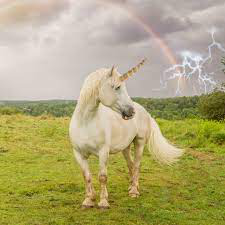

In [16]:
# save the picture from the url to a file called unicorn.jpg
dest = 'test.jpg'
download_url(url, dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [17]:
is_unicorn,_,probs = learn.predict('test.jpg')
print(f"This is a: {is_unicorn}.")
print(f"Probability it is a unicorn: {probs[1]:.4f}")

This is a: horse.
Probability it is a unicorn: 0.0006
